#Partiendo de la limpieza de datos realizada previamente, se utiliza LSTM para predecir la producción de pozos de petroleo.





In [ ]:
import math
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Trabajo profesional/Code/data/prod_merge_2024-03-30_02:38:49.csv", index_col=0)
dataset.info()

<ipython-input-3-02f40d5a2f1d>:2: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("/content/drive/MyDrive/Trabajo profesional/Code/data/prod_merge_2024-03-30_02:38:49.csv", index_col=0)


<class 'pandas.core.frame.DataFrame'>
Index: 276318 entries, 0 to 276317
Data columns (total 53 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   idempresa                276318 non-null  object 
 1   anio                     276318 non-null  int64  
 2   mes                      276318 non-null  int64  
 3   idpozo                   276318 non-null  int64  
 4   prod_pet                 276318 non-null  float64
 5   prod_gas                 276318 non-null  float64
 6   prod_agua                276318 non-null  float64
 7   iny_agua                 276318 non-null  float64
 8   iny_gas                  276318 non-null  float64
 9   iny_co2                  276318 non-null  float64
 10  iny_otro                 276318 non-null  float64
 11  tef                      276318 non-null  float64
 12  vida_util                5813 non-null    float64
 13  tipoextraccion           276318 non-null  object 
 14  tipoestad

In [ ]:
mes_values = dataset['mes'].values

# Analisis exploratorio para ver los posibles valores de los meses.
print("Values of the 'mes' column:")
#for value in mes_values:
#  print(value)

for i, value in enumerate(mes_values):
    if i < 10:
        print(value)
    else:
        break

Values of the 'mes' column:
1
1
1
1
2
2
2
2
3
3


In [ ]:
# Buscamos los pozos con mayor produccion, pero solo como análisis exploratorio.
dataset.groupby(["idpozo"])["prod_pet"].sum().sort_values()

idpozo
164767         0.00
158087         0.00
158086         0.00
161110         0.00
147538         0.00
            ...    
160693    160547.21
160932    168272.26
160694    177977.27
159848    182093.69
162246    182818.81
Name: prod_pet, Length: 3717, dtype: float64

In [ ]:
# NO USADO PARA ESTAS PREDICCIONES.
test_dataset = pd.read_csv("/content/drive/MyDrive/Trabajo profesional (private)/deleted_rows_test_dataset.csv", index_col=0)

In [ ]:
# NO USADO PARA ESTAS PREDICCIONES.
# Extract the relevant features
#features = dataset[['anio', 'mes', 'idpozo', 'prod_pet']].values

# Select all columns except for the target variable 'prod_pet'
features_prod_pet = dataset.drop(columns=['prod_pet']).values

features_prod_pet


In [ ]:
# PRIMERA OPCION - PRECISION MEDIA.

# Extract the relevant features
features = dataset[['anio', 'mes', 'idpozo', 'prod_pet']].values

# Select all columns except for the target variable 'prod_pet'
#features = dataset.drop(columns=['prod_pet']).values

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Define the sequence length (number of time steps to look back)
sequence_length = 6

# Convert data into sequences
# Las secuencias de entrada proporcionan la información necesaria para el modelo
# aprender los patrones en los datos, mientras que las secuencias de salida
# representan los resultados esperados que el modelo intentará predecir.
# Durante el entrenamiento del modelo, se ajustan los parámetros del modelo para
# minimizar la diferencia entre las secuencias de salida predichas y las
# secuencias de salida reales.
A, b = [], []
#for i in range(len(scaled_features) - sequence_length):
#    A.append(scaled_features[i:i+sequence_length, :-1])
#    b.append(scaled_features[i+sequence_length, -1])

for i in range(len(scaled_features) - sequence_length - 1):
    A.append(scaled_features[i:i+sequence_length, :-1])
    b.append(scaled_features[i+sequence_length, -1])

A, b = np.array(A), np.array(b)

# Split data into train and test sets
train_size = int(len(A) * 0.8)
A_train, A_test = A[:train_size], A[train_size:]
b_train, b_test = b[:train_size], b[train_size:]

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,
               input_shape=(A_train.shape[1], A_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(A_train, b_train, epochs=10, batch_size=32)

# Evaluate the model
loss = model.evaluate(A_test, b_test)
print('Test Loss:', loss)

# Make predictions
predictions_A = model.predict(A_test)

Epoch 1/10
6908/6908 [==============================] - 72s 10ms/step - loss: 0.0018
Epoch 2/10
6908/6908 [==============================] - 67s 10ms/step - loss: 0.0016
Epoch 3/10
6908/6908 [==============================] - 65s 9ms/step - loss: 0.0016
Epoch 4/10
6908/6908 [==============================] - 66s 10ms/step - loss: 0.0016
Epoch 5/10
6908/6908 [==============================] - 67s 10ms/step - loss: 0.0016
Epoch 6/10
6908/6908 [==============================] - 67s 10ms/step - loss: 0.0015
Epoch 7/10
6908/6908 [==============================] - 66s 10ms/step - loss: 0.0015
Epoch 8/10
6908/6908 [==============================] - 67s 10ms/step - loss: 0.0015
Epoch 9/10
6908/6908 [==============================] - 65s 9ms/step - loss: 0.0015
Epoch 10/10
1727/1727 [==============================] - 7s 3ms/step - loss: 0.0019
Test Loss: 0.001855881535448134
1727/1727 [==============================] - 8s 4ms/step


Mean Absolute Error: 0.02171699824179155
Mean Squared Error: 0.0018558817386394922
Root Mean Squared Error: 0.04307994589875308


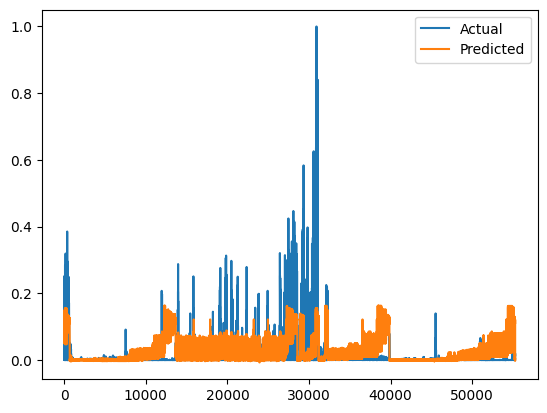

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_A = mean_absolute_error(b_test, predictions_A)
print('Mean Absolute Error:', mae_A)

from sklearn.metrics import mean_squared_error
mse_A = mean_squared_error(b_test, predictions_A)
print('Mean Squared Error:', mse_A)

rmse_A = np.sqrt(mse_A)
print('Root Mean Squared Error:', rmse_A)

plt.plot(b_test, label='Actual')
plt.plot(predictions_A, label='Predicted')
plt.legend()
plt.show()

In [ ]:
# Cada predicción en el array predictions es un valor pronosticado de la variable
# objetivo ('prod_pet') para una muestra específica en el conjunto de datos de prueba.

# En el código, estamos utilizando un modelo LSTM para predecir los valores de
# 'prod_pet' en función de las características de entrada (por ejemplo, 'anio', 'mes', 'idpozo').
# Después de entrenar el modelo, realizamos predicciones en el conjunto de datos de
# prueba usando la función model.predict(X_test), que devuelve un array de valores predichos.

# Cada predicción corresponde a una muestra en el conjunto de datos de prueba.
# Por ejemplo, si tenemos 100 muestras en el conjunto de datos de prueba, tendremos
# 100 predicciones en el array predictions.

# Cada predicción representa el valor pronosticado por el modelo para la variable
# 'prod_pet' para la muestra correspondiente en el conjunto de datos de prueba.
# Estos valores estan escalados (normalizados) porque aplicamos un escalado
# de características durante el preprocesamiento. Si se quiere interpretar las
# predicciones en la escala original, se debe invertir la transformación
# usando el mismo escalador que utilizamos durante el preprocesamiento.

#print("Predicted 'prod_pet' values:")
#for pred in predictions:
#    print(pred)

for i, pred in enumerate(predictions_A):
    if i < 10:
        print(pred)
    else:
        break

[0.08489525]
[0.0504449]
[0.14920428]
[0.08425386]
[0.05205694]
[0.14648384]
[0.08359635]
[0.0538692]
[0.14392981]
[0.08301176]


In [ ]:
# SEGUNDA OPCION - PRECISION MUY BAJA.
# SIN normalizar, los errores son muy altos. Por ende, la solucion utilizada
# a continuacion, no la utilizaremos porque tiene mucho error.

# Extract the relevant features
features = dataset[['anio', 'mes', 'idpozo', 'prod_pet']].values

# Define the sequence length (number of time steps to look back)
sequence_length = 6

# Convert data into sequences
C, d = [], []
for i in range(len(features) - sequence_length - 1):
    C.append(features[i:i+sequence_length, :-1])
    d.append(features[i+sequence_length, -1])

C, d = np.array(C), np.array(d)

# Split data into train and test sets
train_size = int(len(C) * 0.8)
C_train, C_test = C[:train_size], C[train_size:]
d_train, d_test = d[:train_size], d[train_size:]

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,
               input_shape=(C_train.shape[1], C_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(C_train, d_train, epochs=10, batch_size=32)

# Evaluate the model
loss = model.evaluate(C_test, d_test)
print('Test Loss:', loss)

# Make predictions
predictions_C = model.predict(C_test)


Epoch 1/10
6908/6908 [==============================] - 68s 9ms/step - loss: 626055.9375
Epoch 2/10
6908/6908 [==============================] - 66s 10ms/step - loss: 607267.0000
Epoch 3/10
6908/6908 [==============================] - 66s 10ms/step - loss: 606716.6875
Epoch 4/10
6908/6908 [==============================] - 64s 9ms/step - loss: 606709.8125
Epoch 5/10
6908/6908 [==============================] - 66s 10ms/step - loss: 606706.4375
Epoch 6/10
6908/6908 [==============================] - 66s 10ms/step - loss: 606703.5000
Epoch 7/10
6908/6908 [==============================] - 72s 10ms/step - loss: 606739.4375
Epoch 8/10
6908/6908 [==============================] - 73s 11ms/step - loss: 606715.5625
Epoch 9/10
6908/6908 [==============================] - 67s 10ms/step - loss: 606710.1875
Epoch 10/10
1727/1727 [==============================] - 8s 4ms/step - loss: 371607.7188
Test Loss: 371607.71875
1727/1727 [==============================] - 7s 3ms/step


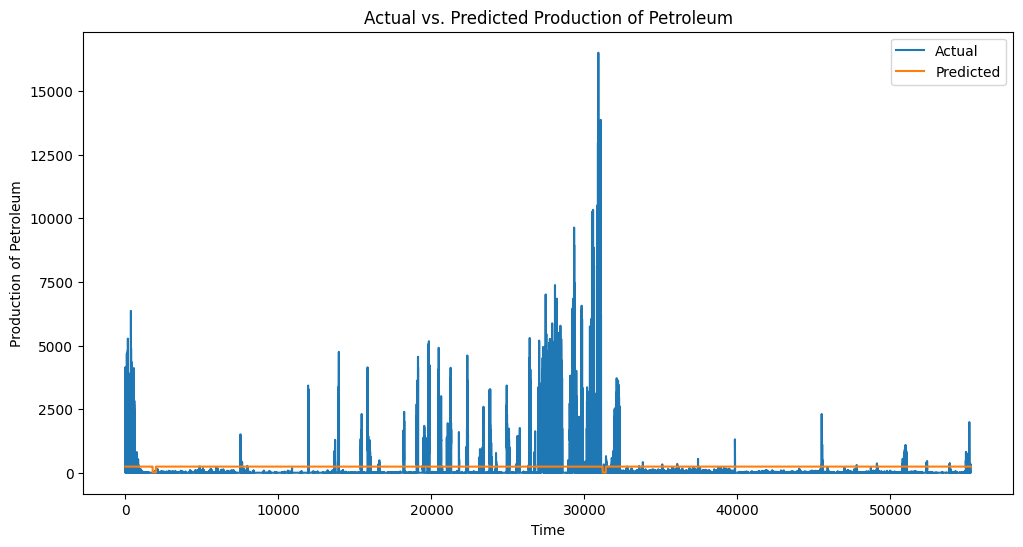

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(d_test, label='Actual')
plt.plot(predictions_C, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Production of Petroleum')
plt.title('Actual vs. Predicted Production of Petroleum')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mae_C = mean_absolute_error(d_test, predictions_C)
print('Mean Absolute Error:', mae_C)


Mean Absolute Error: 310.6059256935797


In [ ]:
from sklearn.metrics import mean_squared_error
mse_C = mean_squared_error(d_test, predictions_C)
print('Mean Squared Error:', mse_C)

Mean Squared Error: 371608.2336183952


In [ ]:
rmse_C = np.sqrt(mse_C)
print('Root Mean Squared Error:', rmse_C)


Root Mean Squared Error: 609.5967795341403


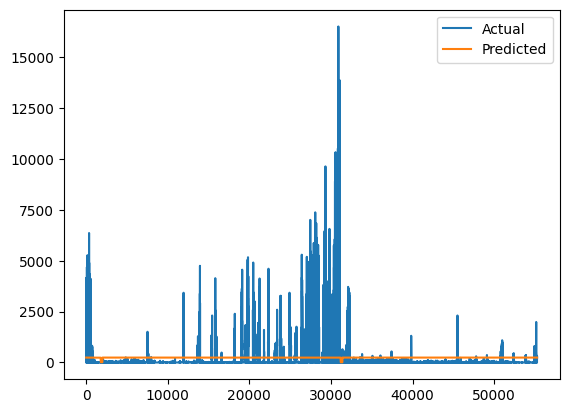

In [ ]:
plt.plot(d_test, label='Actual')
plt.plot(predictions_C, label='Predicted')
plt.legend()
plt.show()

In [ ]:
# NO USADO. VALIDAR SI SIRVE.
#residuals = d_test - predictions
#plt.plot(residuals)
#plt.xlabel('Index')
#plt.ylabel('Residual')
#plt.title('Residual Plot')
#plt.show()

In [ ]:
# TERCERA OPCION - MAS PRECISA.

# Seleccionar características relevantes
features = ['prod_pet', 'anio', 'mes', 'idpozo']

# Filtrar características
data = dataset[features]

# Preprocesamiento de datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Función para crear secuencias de datos y etiquetas
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # prod_pet es la primera columna
    return np.array(X), np.array(y)

# Definir longitud de la secuencia temporal
seq_length = 10  # Valor ajustable

# Crear secuencias de datos y etiquetas
X, y = create_sequences(scaled_data, seq_length)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construir modelo LSTM
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compilar modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluar modelo
loss = model.evaluate(X_test, y_test)
print('Loss:', loss)

# Hacer predicciones
predictions_X = model.predict(X_test)

Epoch 1/50
6908/6908 [==============================] - 56s 8ms/step - loss: 0.0010 - val_loss: 6.1700e-04
Epoch 2/50
6908/6908 [==============================] - 58s 8ms/step - loss: 9.1339e-04 - val_loss: 5.7334e-04
Epoch 3/50
6908/6908 [==============================] - 54s 8ms/step - loss: 8.1817e-04 - val_loss: 5.6031e-04
Epoch 4/50
6908/6908 [==============================] - 52s 8ms/step - loss: 7.5853e-04 - val_loss: 5.6215e-04
Epoch 5/50
6908/6908 [==============================] - 54s 8ms/step - loss: 7.1704e-04 - val_loss: 5.0206e-04
Epoch 6/50
6908/6908 [==============================] - 55s 8ms/step - loss: 6.9180e-04 - val_loss: 4.9274e-04
Epoch 7/50
6908/6908 [==============================] - 54s 8ms/step - loss: 6.6124e-04 - val_loss: 4.8619e-04
Epoch 8/50
6908/6908 [==============================] - 54s 8ms/step - loss: 6.3698e-04 - val_loss: 5.5420e-04
Epoch 9/50
6908/6908 [==============================] - 54s 8ms/step - loss: 6.1518e-04 - val_loss: 4.7142e-04
Epoch

Mean Absolute Error _X: 0.005959401576988676
Mean Squared Error _X: 0.00043420322304416596
Root Mean Squared Error _X: 0.020837543594295512


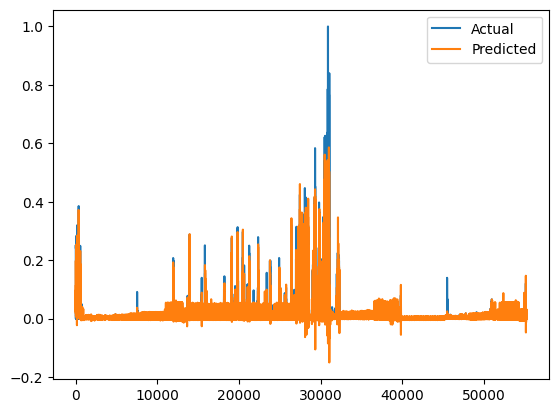

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_X = mean_absolute_error(y_test, predictions_X)
print('Mean Absolute Error _X:', mae_X)

from sklearn.metrics import mean_squared_error
mse_X = mean_squared_error(y_test, predictions_X)
print('Mean Squared Error _X:', mse_X)

rmse_X = np.sqrt(mse_X)
print('Root Mean Squared Error _X:', rmse_X)

plt.plot(y_test, label='Actual')
plt.plot(predictions_X, label='Predicted')
plt.legend()
plt.show()

In [ ]:
for i, pred in enumerate(predictions_X):
    if i < 10:
        print(pred)
    else:
        break

[0.11150711]
[0.07063086]
[0.01797339]
[0.19836225]
[0.06896105]
[0.02215151]
[0.18185386]
[0.07066752]
[0.0283896]
[0.15715016]


In [ ]:
# TODOS LOS ERRORES CALCULADOS A MODO DE RESUMEN

# PRIMERA OPCION:
print('Mean Absolute Error _A:', mae_A)
print('Mean Squared Error _A:', mse_A)
print('Root Mean Squared Error _A:', rmse_A)

# SEGUNDA OPCION:
print('Mean Absolute Error _C:', mae_C)
print('Mean Squared Error _C:', mse_C)
print('Root Mean Squared Error _C:', rmse_C)

# TERCERA OPCION:
print('Mean Absolute Error _X:', mae_X)
print('Mean Squared Error _X:', mse_X)
print('Root Mean Squared Error _X:', rmse_X)

Mean Absolute Error _A: 0.02171699824179155
Mean Squared Error _A: 0.0018558817386394922
Root Mean Squared Error _A: 0.04307994589875308
Mean Absolute Error _C: 310.6059256935797
Mean Squared Error _C: 371608.2336183952
Root Mean Squared Error _C: 609.5967795341403
Mean Absolute Error _X: 0.005959401576988676
Mean Squared Error _X: 0.00043420322304416596
Root Mean Squared Error _X: 0.020837543594295512


In [ ]:
# PROBAR ESTO: Invertir la escala de las predicciones
predictions_unscaled = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], X_test.shape[1]), predictions_X), axis=1))[:, -1]